In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

from pathlib import Path
import itertools
from multiprocessing import Pool
from tqdm.auto import tqdm
import re

import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
import matplotlib.colors

import noctiluca as nl

import loading

In [2]:
path = Path('../../raw_data/MINFLUX/production/npy')
files = list(path.rglob('*.npy'))
print(f"{len(files)} files total; e.g.")
print(str(files[0]))

577 files total; e.g.
../../raw_data/MINFLUX/production/npy/array/C36/NT1/240826-115342_minflux.npy


In [3]:
def filename2tags(f):
    s = str(f)
    tags = set()
    
    # filenames in this case have a simple format:
    # <"array"|"H2B">/<cell line>/<treatment,rep>/*.npy
    # (note that this function will get paths relative to `path`)
    
    system, cell_line, treatment_rep, fname = f.parts
    
    m = re.match('(\w+)(\d[\dabc]*)', treatment_rep)
    assert m
    treatment, rep = m[1], m[2]
    
    tags |= {   'system='+system,    system,
             'cell_line='+cell_line, cell_line,
             'treatment='+treatment, treatment,
                   'rep='+rep,       treatment_rep,
            }
    
    return tags

In [4]:
dt_dict = {}
data = nl.TaggedSet()
for f in tqdm(files):
    data |= loading.load_file(f, path, dt_dict, filename2tags)

  0%|          | 0/577 [00:00<?, ?it/s]

/home/sgh/projects/Hansenlab/2025-05_minflux_for_repo/02_data_processing/01_MINFLUX/loading.py:53: OptimizeWarning: Covariance of the parameters could not be estimated
  res = optimize.curve_fit(lambda x, a: a*x,


array: 191.03773483911897
H2B  : 216.30103874418802


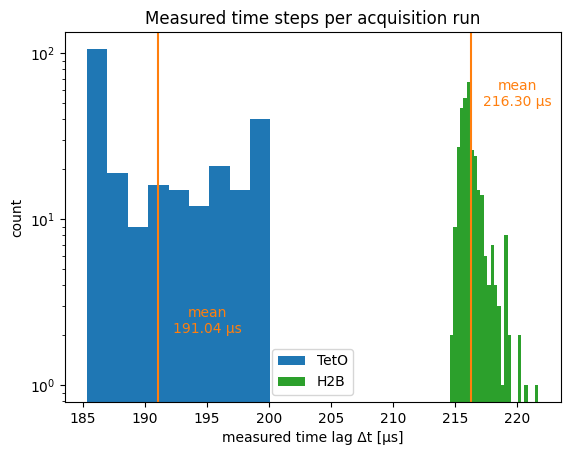

185.33597460040383 array/dRAD21/ctrl3/240827-180322_minflux.npy
185.47769031851442 array/dRAD21/IAA1/240826-135716_minflux.npy
185.48204792144872 array/dRAD21/IAA1/240826-134103_minflux.npy
185.48273062399335 array/dRAD21/IAA3/240827-172442_minflux.npy
185.52859570083493 array/C36/NT2/240827-092041_minflux.npy
185.55149391970699 array/dRAD21/IAA1/240826-132031_minflux.npy
185.55765220803704 array/dRAD21/ctrl3/240827-175718_minflux.npy
185.5601306219407 array/dRAD21/ctrl3/240827-181157_minflux.npy
185.57881694200736 array/dRAD21/ctrl1/240826-182441_minflux.npy
185.5848242015811 array/dRAD21/ctrl3/240827-175508_minflux.npy
185.60601108329243 array/dRAD21/ctrl1/240826-184741_minflux.npy
185.61544159312308 array/dRAD21/ctrl1/240826-185135_minflux.npy
185.63009678764192 array/dRAD21/ctrl1/240826-184622_minflux.npy
185.63078907366798 array/dRAD21/ctrl1/240826-183954_minflux.npy
185.63814168257178 array/dRAD21/ctrl1/240826-183036_minflux.npy
185.6383566843361 array/dRAD21/ctrl1/240826-183916_

In [10]:
# Check time steps
dts = np.array([dt_dict[f] for f in dt_dict])
fs  = np.array([f          for f in dt_dict])

dts_array = dts[np.array(['array' in f for f in dt_dict])] * 1e6
dts_H2B   = dts[np.array(['H2B'   in f for f in dt_dict])] * 1e6

print('array:', np.mean(dts_array))
print('H2B  :', np.mean(dts_H2B))

plt.hist(dts_array,
         bins='auto',
         label='TetO',
        )
plt.axvline(np.mean(dts_array), color='tab:orange')
plt.text(195, 3, f'mean\n{np.mean(dts_array):.2f} μs',
         ha='center', va='top',
         color='tab:orange',
        )

plt.hist(dts_H2B,
         bins='auto',
         label='H2B',
         color='tab:green',
        )
plt.axvline(np.mean(dts_H2B), color='tab:orange')
plt.text(220, 70, f'mean\n{np.mean(dts_H2B):.2f} μs',
         ha='center', va='top',
         color='tab:orange',
        )

plt.legend()
plt.yscale('log')
plt.xlabel('measured time lag Δt [μs]')
plt.ylabel('count')
plt.title('Measured time steps per acquisition run')

# plt.savefig('time_steps.pdf')
plt.show()

ind = np.argsort(dts)
for i in ind:
    print(dts[i]*1e6, str(fs[i]))

In [6]:
# Some cleanup
data.makeSelection(lambda traj, _: traj.F < 2)
print(f"Deleting {len(data)} trajectories with < 2 localizations")
data.deleteSelection()

# Cut off first localization (bc that's the first one, where we have to search for the locus)
data.makeSelection()
for traj in data:
    i_start = np.nonzero(np.cumsum(~np.isnan(traj.abs()[:][:, 0])) == 2)[0][0]
    traj.data = traj.data[:, i_start:, :]

Deleting 449 trajectories with < 2 localizations


In [7]:
data.makeSelection()
idents = ['system', 'cell_line', 'treatment', 'rep']
ident_tags = {ident : sorted({tag for tag in data.tagset() if tag.startswith(ident+'=')})
              for ident in idents
             }

tagsets = []
for tags in itertools.product(*ident_tags.values()):
    tags = set(tags)
    data.makeSelection(tags, logic=all)
    if len(data) > 0:
        tagsets.append(tags)
            
print('#trajs     tags')
print(50*'-')
            
N_total = 0
for tags in tagsets:
    data.makeSelection(tags, logic=all)
    taglist = []
    for ident in idents:
        tgs = {tag for tag in tags if tag.startswith(ident+'=')}
        if len(tgs) > 0:
            taglist.append(tgs.pop())
            
    print(f'{len(data):5d}      '+(len(taglist)*'{:20s}').format(*taglist))
    N_total += len(data)

print(50*'-')
data.makeSelection(lambda _, tags: not any(all(tag in tags for tag in tagset)
                                           for tagset in tagsets))
print(f'{len(data):5d}      '+'<none of the above; just to check>')

print(50*'-')
data.makeSelection()
print(f'{N_total:5d}      '+'sum of above')
print(f'{len(data):5d}      '+'total in data set')

#trajs     tags
--------------------------------------------------
 2537      system=H2B          cell_line=U2OS      treatment=DRB       rep=1               
 2020      system=H2B          cell_line=U2OS      treatment=DRB       rep=2               
 1523      system=H2B          cell_line=U2OS      treatment=DRB       rep=3               
 3270      system=H2B          cell_line=U2OS      treatment=ICRF      rep=1               
 2060      system=H2B          cell_line=U2OS      treatment=ICRF      rep=2               
 2262      system=H2B          cell_line=U2OS      treatment=ICRF      rep=3               
 2594      system=H2B          cell_line=U2OS      treatment=TSA       rep=1               
 1533      system=H2B          cell_line=U2OS      treatment=TSA       rep=2               
 1900      system=H2B          cell_line=U2OS      treatment=TSA       rep=3               
 2820      system=H2B          cell_line=U2OS      treatment=ctrl      rep=1               
 1820      sy

In [8]:
def tags2label(tags, omit=set()):
    taglist = []
    for ident in ['system', 'cell_line', 'treatment']: # pooling reps for now
        if ident in omit:
            continue
            
        tgs = {tag for tag in tags if tag.startswith(ident+'=')}
        if len(tgs) > 0:
            tag = tgs.pop()
            val = re.match(ident+'=(.*)', tag)[1]
            taglist.append(val)
    
    return ', '.join(taglist)

In [9]:
conditions = []
for tags in tagsets:
    data.makeSelection(tags, logic=all)
    cond = tags2label(tags)
    data.addTags({cond, 'condition='+cond})
    conditions.append(cond)
    
conditions = np.unique(conditions).tolist()

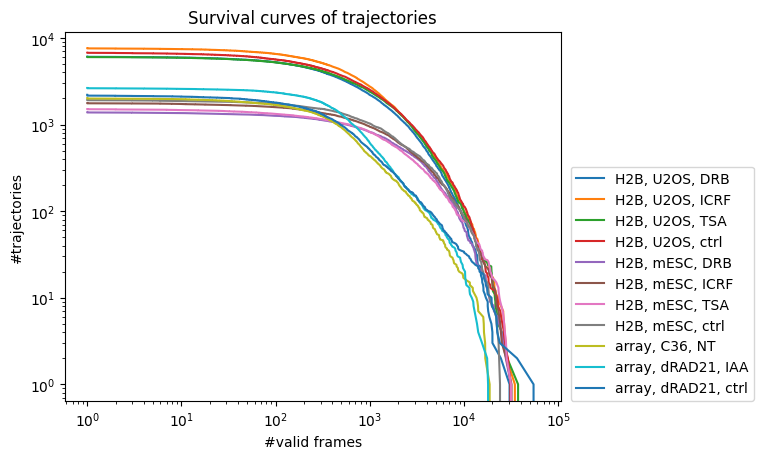

In [11]:
# Check survival curves
for cond in conditions:
    data.makeSelection(cond)
    
    lens = np.flip(np.sort(list(map(len, data))))
    Fs   = np.flip(np.sort(list(map(lambda traj : traj.F, data))))

    plt.plot(lens, np.arange(len(lens)), label=cond)
    # plt.plot(Fs, np.arange(len(Fs)))

plt.xscale('log')
plt.yscale('log')
plt.xlabel('#valid frames')
plt.ylabel('#trajectories')
plt.title('Survival curves of trajectories')
plt.legend(loc=(1.02, 0.0))

plt.show()

In [12]:
# Pre-compute MSDs
data.makeSelection()
with nl.Parallelize():
    _ = nl.analysis.MSD(data, chunksize=10, show_progress=True)

  0%|          | 0/39881 [00:00<?, ?it/s]

In [13]:
outfile = Path('../../data/20250302_minflux_raw.h5')

data.makeSelection()
nl.io.write.hdf5({
    'data'       : data,
    'conditions' : conditions,
    'tagsets'    : tagsets,
    'dt_dict'    : dt_dict,
    'description' : """
Production data for MINFLUX acquisition

array and H2B data, raw, with pre-computed MSDs

Contents of this file:
 - 'data'       : the data
 - 'conditions' : list of strings identifying each of the conditions;
                  can be used as tags in 'data' (replicates are pooled)
 - 'tagsets'    : list of sets of tags into 'data', corresponding to
                  'conditions' (replicates separate); might be useful
 - 'dt_dict'    : lag time extracted from each file. Note that trajectories
                  in 'data' also have meta-entries 'dt'. Note that for proper
                  pooling, one might want to pool these time steps as well.
                  Time steps seem to be
                   - array ~ 190μs
                   - H2B ~ 216μs

Other notes:
 - The array data still contain background traces, which need to be removed
 - Likewise, we did not (yet) filter out short trajectories
 - the first localization of each trajectory has been removed
 - MSDs are pre-calculated for all trajectories
"""[1:-1],
}, outfile)